In [13]:
import numpy as np
from scipy.sparse import linalg as lg
import exact_diagonalization as ed
import utils
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

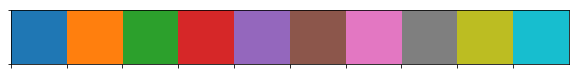

In [14]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = 26

cp = sns.color_palette()
sns.palplot(cp)
plt.show()

Set parameters and calculate exact evolutions

In [2]:
n_sites = 4
time_steps = 50
h_init = 1.0
h_ev = 0.5

t = np.linspace(0.0, 1.0, time_steps + 1)
dt = t[1] - t[0]

ham = utils.tfim_hamiltonian(n_sites, h=h_ev)
exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

Construct clock without penalty term and solve the system to find evolution

In [4]:
clock = ed.construct_sparse_clock(ham, dt, time_steps)
system_state = ed.solve_evolution_system(clock, exact_state[0], lg.gmres)
print(system_state.shape)

print("Overlap with exact: {}".format(utils.overlap(exact_state, system_state)))
print("Average overlap with exact: {}".format(utils.averaged_overlap(exact_state, system_state)))

Convergence status: 0
(51, 16)
Overlap with exact: 0.9999495483074702
Average overlap with exact: 0.9999824413222875


Repeat for various values of $T$

In [20]:
T_list = np.arange(20, 340, 20)
overlaps = {"full": [], "averaged": []}
for time_steps in T_list:
    t = np.linspace(0.0, 1.0, time_steps + 1)
    dt = t[1] - t[0]
    exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
    clock = ed.construct_sparse_clock(ham, dt, time_steps)
    system_state = ed.solve_evolution_system(clock, exact_state[0], lg.gmres)
    overlaps["full"].append(utils.overlap(exact_state, system_state))
    overlaps["averaged"].append(utils.averaged_overlap(exact_state, system_state))
    
for k in overlaps.keys():
    overlaps[k] = np.array(overlaps[k])

Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0
Convergence status: 0


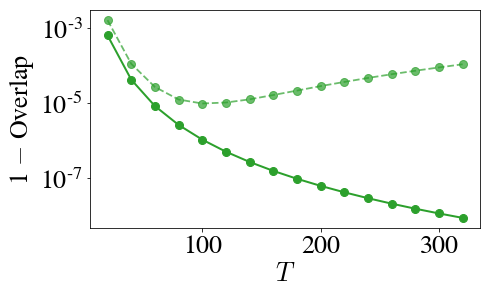

In [21]:
plt.figure(figsize=(7, 4))
plt.semilogy(T_list, 1 - overlaps["averaged"], marker="o", linewidth=2.0, markersize=8, color=cp[2])
plt.semilogy(T_list, 1 - overlaps["full"], "--", marker="o", linewidth=1.8, markersize=8, color=cp[2], alpha=0.7)
plt.xlabel("$T$")
plt.ylabel("1 $-$ Overlap")
plt.show()

Solve eigenvalue problem for Hamiltonian with penalty term

In [53]:
n_sites = 4
h_init = 1.0
h_ev = 0.5
time_steps = 60
penalty = 100.0

t = np.linspace(0.0, 1.0, time_steps + 1)
dt = t[1] - t[0]
exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
clock = ed.construct_sparse_clock(ham, dt, time_steps)

clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
clock_pen = np.array(clock_pen.todense())

system_state = ed.solve_evolution_system(clock, exact_state[0], lg.gmres)
eigvals, eigvecs = np.linalg.eigh(clock_pen)
eig_state = eigvecs[:, 0].reshape(exact_state.shape)

print("Penalty: {}".format(penalty))
print("\nSystem - Exact: {}".format(utils.averaged_overlap(exact_state, system_state)))
print("Eig - Exact: {}".format(utils.averaged_overlap(exact_state, eig_state)))
print("System - Eig: {}".format(utils.averaged_overlap(eig_state, system_state)))

Convergence status: 0
Penalty: 100.0

System - Exact: 0.9999915447002705
Eig - Exact: 0.9999911617630337
System - Eig: 0.9999999947186425


In [54]:
clock_ev = lambda state: state.ravel().conj().dot(clock_pen.dot(state.ravel())) / (np.abs(state)**2).sum()

print("Exact: {}".format(clock_ev(exact_state)))
print("System: {}".format(clock_ev(system_state)))
print("Eig: {}".format(clock_ev(eig_state)))

Exact: (5.601020350488417e-06+1.4994427176444014e-18j)
System: (5.6423295843749975e-06-8.868954500626158e-18j)
Eig: (5.5836150606403935e-06-3.1520213549700647e-19j)


Check how changing the penalty coefficient affects the overlap between exact and lowest eigenstate

In [56]:
n_sites = 4
h_init = 1.0
h_ev = 0.5
time_steps = 60
penalty_list = np.linspace(1e-2, 10, 30)

t = np.linspace(0.0, 1.0, time_steps + 1)
dt = t[1] - t[0]
exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

overlaps = {"full": [], "averaged": []}
for penalty in penalty_list:
    clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
    clock_pen = np.array(clock_pen.todense())

    eigvals, eigvecs = np.linalg.eigh(clock_pen)
    eig_state = eigvecs[:, 0].reshape(exact_state.shape)
    
    overlaps["full"].append(utils.overlap(exact_state, eig_state))
    overlaps["averaged"].append(utils.averaged_overlap(exact_state, eig_state))
    print(".", end="")

for k in overlaps.keys():
    overlaps[k] = np.array(overlaps[k])

..............................

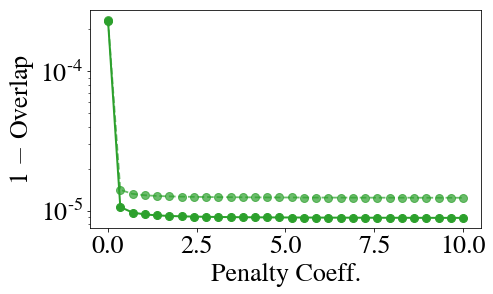

In [60]:
for k in overlaps.keys():
    overlaps[k] = np.array(overlaps[k])
    n = len(overlaps[k])
    
plt.figure(figsize=(7, 4))
plt.semilogy(penalty_list[:n], 1 - overlaps["averaged"], marker="o", linewidth=2.0, markersize=8, color=cp[2])
plt.semilogy(penalty_list[:n], 1 - overlaps["full"], "--", marker="o", linewidth=1.8, markersize=8, color=cp[2], alpha=0.7)
plt.xlabel("Penalty Coeff.")
plt.ylabel("1 $-$ Overlap")
plt.show()

Check how the gap changes as a function of $T$ for constant penalty

In [65]:
n_sites = 4
h_init = 1.0
h_ev = 0.5
T_list = np.arange(20, 220, 20)
penalty = 50.0

gaps = []
for time_steps in T_list:
    t = np.linspace(0.0, 1.0, time_steps + 1)
    dt = t[1] - t[0]
    exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

    clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
    clock_pen = np.array(clock_pen.todense())
    
    eigvals = np.linalg.eigvalsh(clock_pen)
    gaps.append(eigvals[1] - eigvals[0])
    
    print(".", end="")


........

KeyboardInterrupt: 

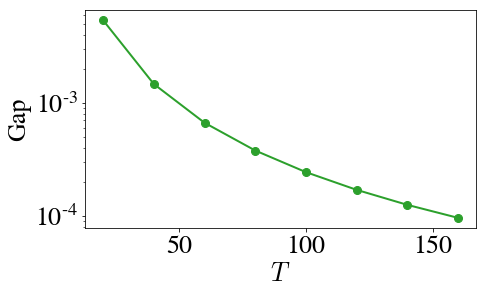

In [66]:
plt.figure(figsize=(7, 4))
plt.semilogy(T_list[:len(gaps)], gaps, marker="o", linewidth=2.0, markersize=8, color=cp[2])
plt.xlabel("$T$")
plt.ylabel("Gap")
plt.show()

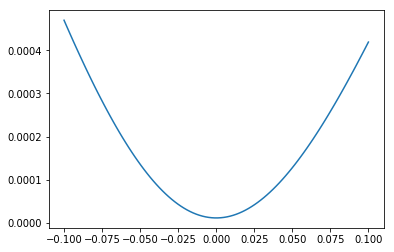

In [3]:
clock = ed.construct_sparse_clock(ham, dt, time_steps)
calculate_clock_ev = lambda Psi: Psi.conj().dot(clock.dot(Psi)) / (np.abs(Psi)**2).sum()
noise = np.linspace(-0.1, 0.1, 100)

clock_evs = np.array([calculate_clock_ev(Psi_exact + ns * np.random.normal(1.0, 1e-3, size=Psi_exact.shape)) 
                      for ns in noise])

plt.plot(noise, clock_evs.real)
plt.show()

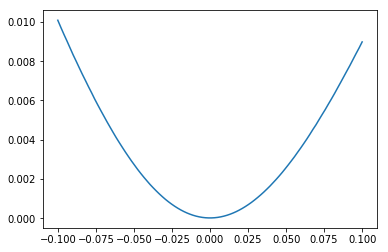

In [4]:
clock = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=10.0, psi0=exact_state[0])
calculate_clock_ev = lambda Psi: Psi.conj().dot(clock.dot(Psi)) / (np.abs(Psi)**2).sum()
noise = np.linspace(-0.1, 0.1, 100)

clock_evs = np.array([calculate_clock_ev(Psi_exact + ns * np.random.normal(1.0, 1e-3, size=Psi_exact.shape)) 
                      for ns in noise])

plt.plot(noise, clock_evs.real)
plt.show()